# CORD Dataset Quick Exploration

In [4]:
# !pip install easyimages

In [5]:
!which python

/home/vantuan5644/anaconda3/envs/ReceiptOCR/bin/python


In [6]:
import sys
sys.executable

'/home/vantuan5644/anaconda3/envs/ReceiptOCR/bin/python'

In [7]:
from easyimages import EasyImageList

In [8]:
image_list = EasyImageList.from_folder('../datasets/CORD/CORD/train/image')

In [9]:
image_list.symlink_images()

In [10]:
%matplotlib inline

In [11]:
image_list.html(sample=10, size=20)

## Padding images

In [1]:
import cv2 as cv
import os

In [2]:
def padding_image(img_path, output_dir=None, padding='mirror'):
    """
    @param padding: 'mirror', 'zeros'
    """
    src = cv.imread(img_path, cv.IMREAD_COLOR)
    borderType = cv.BORDER_REPLICATE

    top = int(0.1 * src.shape[0])  # shape[0] = rows
    bottom = top
    left = int(0.1 * src.shape[1])  # shape[1] = cols
    right = left
    
    if padding == 'mirror':
        dst = cv.copyMakeBorder(src, top, bottom, left, right, borderType, None)
    elif padding == 'zeros':
        value = [0, 0, 0]
        borderType = cv.BORDER_CONSTANT
        dst = cv.copyMakeBorder(src, top, bottom, left, right, borderType, None, value)

    file_name = os.path.splitext(os.path.split(img_path)[1]) # tuple
    if output_dir is None:
        output_dir = os.path.split(img_path)[0]
    new_file = os.path.join(output_dir, file_name[0] + '_padded' + file_name[1])
    cv.imwrite(new_file, dst)

In [30]:
dataset_dir = '../datasets/COOP/train'
output_dir = '../datasets/COOP/padded'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
for img in os.listdir(dataset_dir):
    img = os.path.join(dataset_dir, img)
    padding_image(img, output_dir=output_dir, padding='zeros')

# Downscaling images

In [3]:
import cv2
import matplotlib.pyplot as plt

In [4]:
    img = '/home/vantuan5644/PycharmProjects/ReceiptOCR/datasets/COOP/bill_coop_04/bill_coop_04/img_8.jpg'
    img = plt.imread(img)
    print(img.dtype)


uint8


In [ ]:
train_image_dir = '../datasets/COOP/padded (original)'
dst_dir = '../datasets/COOP/padded_1280'
image_list = sorted(list(filter(lambda file: True if not file.endswith('.txt') else False, [file for file in os.listdir(train_image_dir) if os.path.isfile(os.path.join(train_image_dir, file))])))

for img_path in image_list:
    img = cv2.imread(os.path.join(train_image_dir, img_path), cv2.IMREAD_UNCHANGED)

#     print('Original Dimensions : ',img.shape)

    dst_width = 1280
    scale_ratio = dst_width / img.shape[1]
    width = dst_width
    height = int(img.shape[0] * scale_ratio)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

#     print('Resized Dimensions : ',resized.shape)
    dst_file = os.path.join(dst_dir, img_path)
    cv2.imwrite(dst_file, resized)


### Read annotations

In [79]:
import os
import numpy as np


In [80]:
train_image_dir = '../datasets/COOP/fine_tuning'

In [81]:
filter(lambda file: True if file.endswith('.txt') and file != 'classes.txt' else False, sorted(os.listdir(dataset_path)))

In [82]:
gt_boxes = []
for file in list(filter(lambda file: True if file.endswith('.txt') and file != 'classes.txt' else False, sorted(os.listdir(train_image_dir)))):
    print(file)
    coors = np.genfromtxt(os.path.join(train_image_dir, file))[:,1:]
    gt_boxes.append(coors)

img_10_padded.txt
img_11_padded.txt
img_12_padded.txt
img_13_padded.txt
img_14_padded.txt
img_15_padded.txt
img_16_padded.txt
img_17_padded.txt
img_18_padded.txt
img_19_padded.txt
img_1_padded.txt
img_20_padded.txt
img_2_padded.txt
img_3_padded.txt
img_4_padded.txt
img_5_padded.txt
img_6_padded.txt
img_7_padded.txt
img_8_padded.txt
img_9_padded.txt


In [83]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [84]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [85]:
# Load images and visualize
train_images_np = []
image_list = sorted(list(filter(lambda file: True if not file.endswith('.txt') else False, [file for file in os.listdir(train_image_dir) if os.path.isfile(os.path.join(train_image_dir, file))])))
for i in range(len(image_list)):
    image_path = os.path.join(train_image_dir, image_list[i])
    print(os.path.split(image_path)[1])
    train_images_np.append(load_image_into_numpy_array(image_path))




img_10_padded.jpg
img_11_padded.jpg
img_12_padded.jpg
img_13_padded.jpg
img_14_padded.jpg
img_15_padded.jpg
img_16_padded.jpg
img_17_padded.jpg
img_18_padded.jpg
img_19_padded.jpg
img_1_padded.jpg
img_20_padded.jpg
img_2_padded.jpg
img_3_padded.jpg
img_4_padded.jpg
img_5_padded.jpg
img_6_padded.jpg
img_7_padded.jpg
img_8_padded.jpg
img_9_padded.jpg


In [86]:

# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
num_classes = 4

category_index = {1: {'id': 1, 'name': 'top_left'}, 2: {'id': 2, 'name': 'top_right'},
                  3: {'id': 3, 'name': 'bottom_left'}, 4: {'id': 4, 'name': 'bottom_right'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')


Done prepping data.


In [87]:
%matplotlib inline

In [88]:
gt_boxes[0]

array([[0.205098, 0.815591, 0.084963, 0.077467],
       [0.195962, 0.299756, 0.06194 , 0.070889],
       [0.945551, 0.812911, 0.073817, 0.086724],
       [0.939978, 0.282826, 0.070711, 0.064799]])

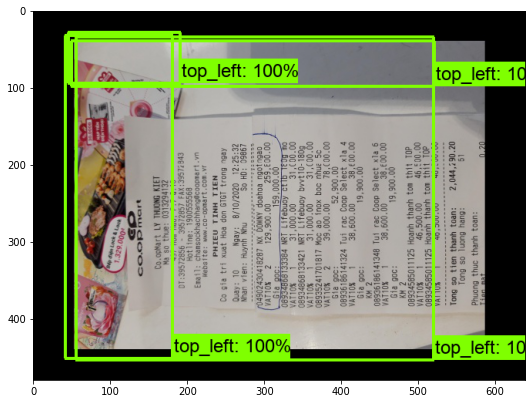

In [89]:
dummy_scores = np.array([1.0, 1.0, 1.0, 1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(1):
    plt.subplot(2, 3, idx+1)
    plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()